# Minimum working example for PROGRESSIVE NET
- Do a simple regression task to demonstrate the handling of the class

## Neccesary Libaries
- PROGRESSIVE NET is torch based, so we need that
- Of course, some additional stuff is also required, depending on what should be done

In [1]:
import torch
import numpy as np
from sklearn import preprocessing
from models.PROGRESSIVE_NET import PROGRESSIVE
import matplotlib.pyplot as plt

#******Control Variables for reproducibility and so on******
torch.manual_seed(41)
np.random.seed(41)
dtype_man = torch.float32
torch.set_default_dtype(dtype_man)

## Data generation
- We choose a simple cubic scalar regression example

In [2]:
#******Data Generation******
# Variance of the noisy data
data_noise = 9.0

# Range definition for training
num_points = 200
border = 4

# Noiseless model
def true_model(x):
    return x**3

# Noisy model
def noisy_model(x,noise):
    noise = torch.sqrt(torch.tensor(noise)) * torch.randn(x.size())
    return true_model(x) + noise 

# Define training range
x = torch.linspace(-border,border,num_points)
x_ext = torch.linspace(-1.5*border,1.5*border,num_points)

# Generate Data
y_gt = true_model(x)                # Ground Truth
y_gt_ext = true_model(x_ext)        # Ground Truth extended
y = noisy_model(x,data_noise)       # Noisy, for Training /Testing

# Normalize input data to be between -1 and 1
x_scaler  = preprocessing.MinMaxScaler(feature_range=(-1,1))
x = torch.tensor(x_scaler.fit_transform(x.unsqueeze(-1)),dtype=dtype_man).squeeze()
x_ext = torch.tensor(x_scaler.transform(x_ext.unsqueeze(-1)), dtype=dtype_man).squeeze()

## Training procedure
- After shuffling the data, perform training with the initialized network

In [4]:
#******Data Shuffling******
perm = torch.randperm(num_points)
x = x[perm]
y = y[perm]

#******Train/Test Split******
split_ratio = 0.8   
x_train = x[:int(split_ratio*num_points)]
y_train = y[:int(split_ratio*num_points)]
x_test = x[int(split_ratio*num_points):]
y_test = y[int(split_ratio*num_points):]

#******Architecture Parameters******
layers = [1,100,1]
act_func = ["relu","linear"]

#******Initialize Model******
algo  = "progressive"
training_type = "sequential"
num_particles = 25000

model = PROGRESSIVE(layers, act_func, num_particles, algo, training_type, meas_variance=data_noise, use_cuda=True)

model.print_info()

#******Train model******
model.train(x_train,y_train)

#******Predict******
y_pred = model.predict(x_test)
pred_mean = y_pred.mean(dim=1)
pred_std = y_pred.std(dim=1)

This network will have 301 weight parameters
Gaussian prior generated
******Network-Information******
Algorithm:  progressive
Mode:  sequential
Number of Layers:  3
Layer Sizes:  [1, 100, 1]
Activation Functions:  [<function relu_handle at 0x0000024D8777BD80>, <function linear_handle at 0x0000024D8777BE20>]
Number of Particles:  25000
*******************************
GPU support enabled.
*****Started Training (Progressive Gauss Filter Random Sampled, Sequential Method)*****


Training (Sequential): 100%|██████████| 160/160 [00:33<00:00,  4.78it/s]


*****Training Finished after  33.45  seconds.*****


Predicting: 100%|██████████| 40/40 [00:00<00:00, 283.49it/s]


## Plot the results


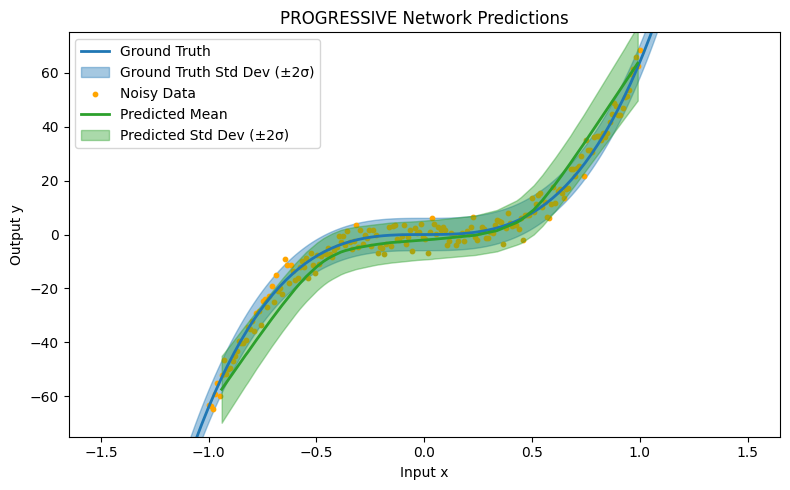

In [5]:
# Sort the test data for plotting
x_test, indices = torch.sort(x_test)
pred_mean = pred_mean[indices]
pred_std = pred_std[indices]

plt.figure(figsize=(8,5))
# Plot the ground truth, noisy data, and predictions
plt.plot(x_ext.numpy(), y_gt_ext.numpy(), label='Ground Truth', color='tab:blue', linewidth=2)
plt.fill_between(x_ext.numpy(), 
                 (y_gt_ext - 2 * torch.sqrt(torch.tensor(data_noise))).numpy(), 
                 (y_gt_ext + 2 * torch.sqrt(torch.tensor(data_noise))).numpy(), 
                 color='tab:blue', alpha=0.4, label='Ground Truth Std Dev (±2σ)')
plt.scatter(x.numpy(), y.numpy(), label='Noisy Data', color='orange', s=10)
plt.plot(x_test.numpy(), pred_mean.numpy(), label='Predicted Mean', color='tab:green', linewidth=2)
plt.fill_between(x_test.numpy(), 
                 (pred_mean - 2 * pred_std).numpy(), 
                 (pred_mean + 2 * pred_std).numpy(), 
                 color='tab:green', alpha=0.4, label='Predicted Std Dev (±2σ)')
plt.ylim(-75,75)
plt.legend()
plt.title('PROGRESSIVE Network Predictions')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.tight_layout()